In [342]:
import sys
import os

import neo.io

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline

import tqdm

from collections import Counter

import pandas as pd

In [255]:
def plot_spikes(spikes, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(15,10))

    for i in range(len(spikes)):
        ax.plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.2)
    
    ax.set_ylim([-5., 5.])

In [256]:
def read_spikes(dist_dir):
    all_data = list()

    for root, subdirs, files in os.walk(dist_dir):
        for full_name, f_name in [(os.path.join(root, f_name), f_name) for f_name in files]:
            patient = full_name.split(os.sep)[3]
            ext = full_name[-3:].lower()

            if ext == 'nex':
                r = neo.io.NeuroExplorerIO(filename=full_name)
                for blk in r.read(cascade=True, lazy=False):
                    for seg in blk.segments:
                        for st in seg.spiketrains:
                            name_lower = str(st.name.lower())
                            if name_lower.startswith('fon'):
                                spikes = np.array(st)
                                for interval in seg.epochs:
                                    int_name = interval.annotations['channel_name'].lower()
                                    if name_lower.startswith(int_name):
                                        for s, d in zip(interval.times, interval.durations):
                                            e = s + d
                                            spikes_filtered = spikes[np.where((spikes >= s) & (spikes <= e))]
                                            if len(spikes_filtered) > 100 and (spikes_filtered[~0] - spikes_filtered[0]) > 5.:
                                                df = dict()
                                                df['st'] = spikes
                                                df['patient'] = patient
                                                df['data_name'] = st.name
                                                df['doc_name'] = f_name
                                                df['interval_name'] = int_name

                                                all_data.append(df)

                            elif name_lower.startswith('allfile') or name_lower.startswith('nw'):
                                spikes = np.array(st)
                                if len(spikes) > 50 and (spikes[~0] - spikes[0] > 5.):                                    
                                    df = dict()
                                    df['st'] = spikes
                                    df['patient'] = patient
                                    df['data_name'] = st.name
                                    df['doc_name'] = f_name
                                    df['interval_name'] = 'allfile'

                                    all_data.append(df)
                                    
    return all_data


In [333]:
stat_data = pd.concat([pd.read_excel('awake.xls'), pd.read_excel('sleep.xls')])

stat_dict = dict()
for idx, row in stat_data.iterrows():
    key = '{};{};{}'.format(row['doc_name'], row['data_name'], row['interval_name'])
    stat_dict[key] = (row['cv'], row['AI'])

In [27]:
dist_dir_a = 'C:\\projects\\neuro_data\\data_for_analyze\\awake'
dist_dir_s = 'C:\\projects\\neuro_data\\data_for_analyze\\sleep'

In [28]:
data_a = read_spikes(dist_dir_a)
data_s = read_spikes(dist_dir_s)

In [372]:
only_st = list()
names = list()

for d in data_a:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['doc_name'], d['data_name'], d['interval_name']))

    if len(only_st) == 50:
        break
        
    
for d in data_s:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['doc_name'], d['data_name'], d['interval_name']))
        
    if len(only_st) == 100:
        break

In [373]:
cv_ai = [stat_dict[n] for n in names]
only_isi = [st[1:] - st[:-1] for st in only_st]
logisi = [np.log(isi[np.nonzero(isi)]) for isi in only_isi]

In [374]:
len(only_st), len(names)

(100, 100)

In [104]:
def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res

In [389]:
def boot_fit(x, dist, iters=100):
    params = np.array([dist.fit(np.random.choice(x, size=len(x))) for _ in range(iters)])
    return np.mean(params, axis=0)

def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (sp.stats.entropy(_P, _M) + sp.stats.entropy(_Q, _M))

def logisi_gamma_metric(x, y):
    x_norm = x/np.max(x)
    y_norm = y/np.max(y)
    
    a1,b1,s1 = sp.stats.gamma.fit(x)
    a2,b2,s2 = sp.stats.gamma.fit(y)
    
    x_axis = np.arange(-10, 10, 0.001)
    d1 = sp.stats.gamma.pdf(x_axis, a1, b1, s1)
    d2 = sp.stats.gamma.pdf(x_axis, a2, b2, s2)
    
    return JSD(d1, d2)


def get_sdh(st, norm = True):
    isi = st[1:] - st[:-1]
    splitted = clever_split(st, np.mean(isi))
    counts = Counter([len(t) for t in splitted])
        
    res = np.zeros(max(counts.keys()) + 1)
    
    for idx, val in counts.items():
        res[idx] = val
    
    
    if(norm):
        res /= sum(res)
    
    return res    


def pad_to_size(arr, sz, val):
    res = np.full(sz, val, dtype=float)
    res[:len(arr)] = arr
    
    return res


def get_sdh_window(st, windows=5):
    splits = np.array_split(st, windows)
    sdh_lst = [get_sdh(spl) for spl in splits]
    max_len = max([len(sdh) for sdh in sdh_lst])
    
    sdh_lst = [pad_to_size(sdh, max_len, 0.) for sdh in sdh_lst]
    
    sdh_total = np.sum(sdh_lst, axis=0)
    
    sdh_total /= sum(sdh_total)
    return sdh_total


def sdh_poisson_metric(x, y, windows=10):
    sdh1 = get_sdh_window(x, windows)
    sdh2 = get_sdh_window(y, windows)
        
    max_len = max(len(sdh1), len(sdh2))

    sdh1 = pad_to_size(sdh1, max_len, 0)
    sdh2 = pad_to_size(sdh2, max_len, 0)

    return JSD(sdh1, sdh2)


def build_matrix(arr, metric):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res

In [210]:
labels = np.zeros(100)
labels[:50] = 1

In [390]:
M_isi = build_matrix(logisi, logisi_gamma_metric)

A Jupyter Widget

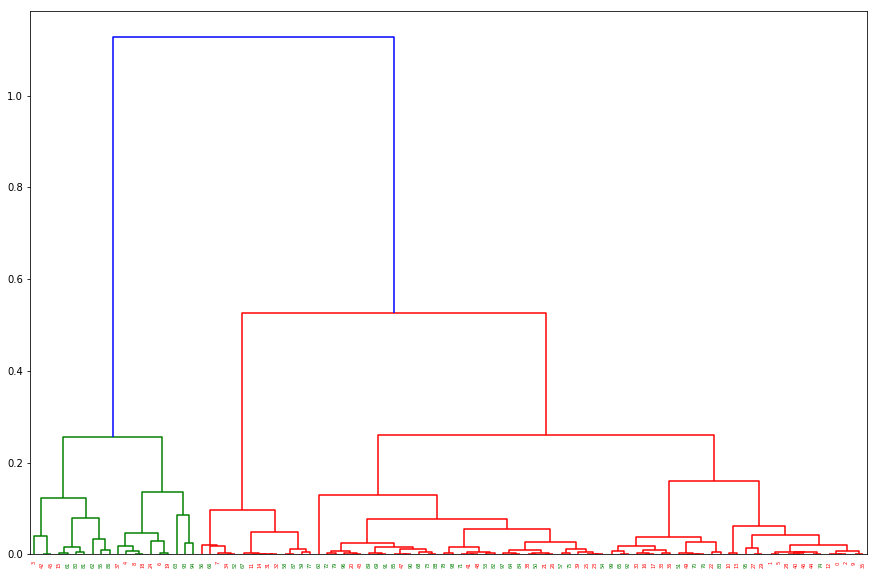

In [391]:
Z_isi = linkage(M_isi[np.triu_indices(M_isi.shape[0], 1)], 'ward')

plt.figure(figsize=(15,10))
d_dct = dendrogram(Z_isi)

ax = plt.gca()

for lbl in ax.get_xmajorticklabels():
    idx = int(lbl.get_text())
    if labels[idx]:
        lbl.set_color('red')
    else:
        lbl.set_color('green')

In [394]:
fcluster(Z_isi, 0.5, criterion="distance")

array([3, 3, 3, 1, 1, 3, 1, 2, 1, 3, 3, 2, 3, 3, 2, 1, 3, 3, 1, 1, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3,
       3, 1, 1, 3, 3, 3, 3, 3], dtype=int32)

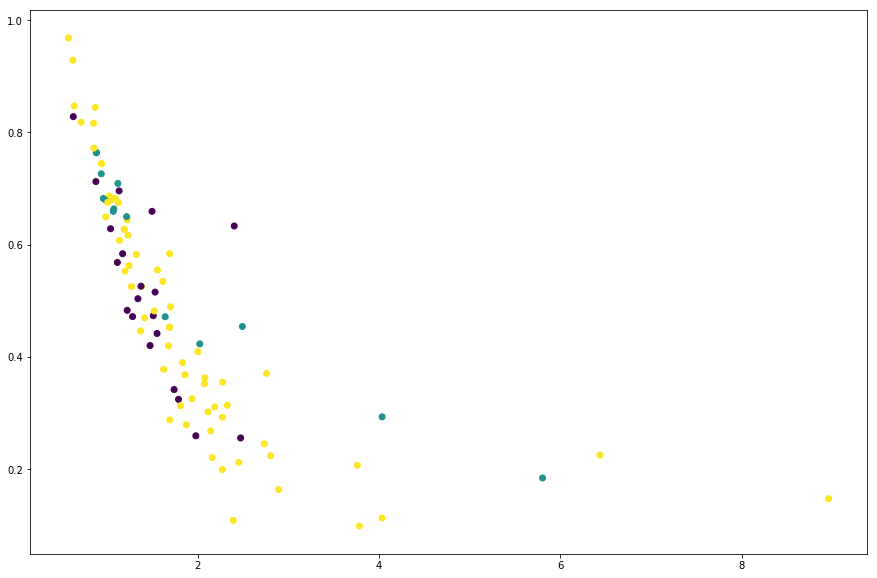

In [396]:
cut_isi = fcluster(Z_isi, 0.5, criterion="distance")
plt.figure(figsize=(15,10))
plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], c=cut_isi)

In [375]:
M = build_matrix(only_st, lambda x, y: sdh_poisson_metric(x, y, 1))

A Jupyter Widget

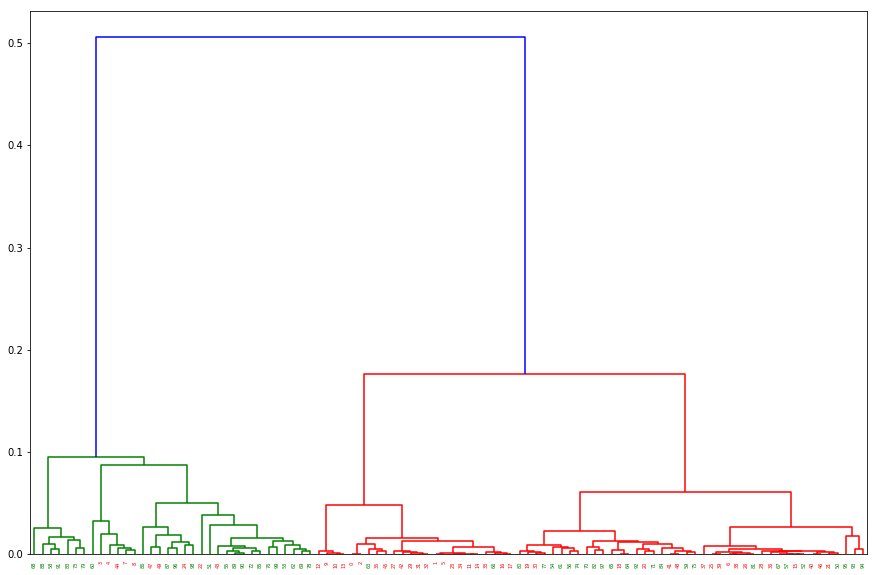

In [376]:
Z = linkage(M[np.triu_indices(M.shape[0], 1)], 'ward')

plt.figure(figsize=(15,10))
d_dct = dendrogram(Z)

ax = plt.gca()

for lbl in ax.get_xmajorticklabels():
    idx = int(lbl.get_text())
    if labels[idx]:
        lbl.set_color('red')
    else:
        lbl.set_color('green')

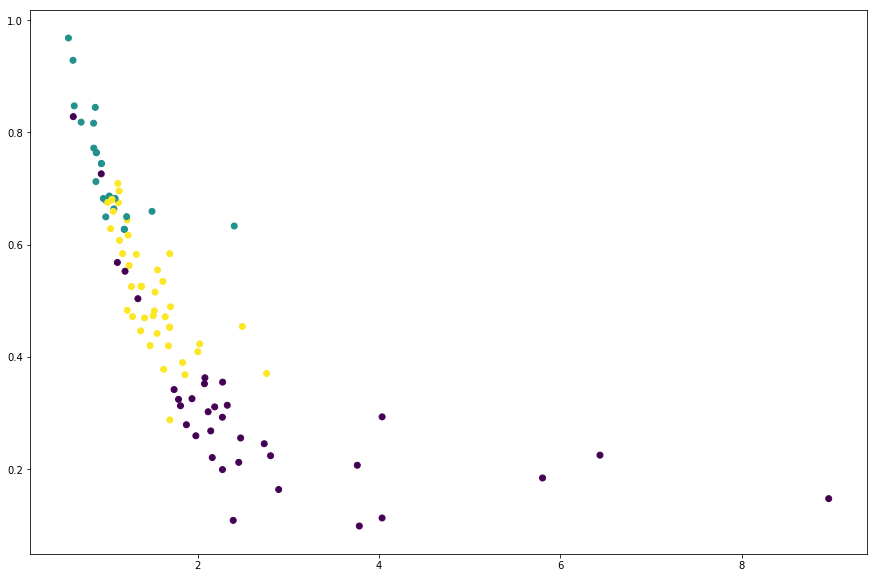

In [384]:
cut = fcluster(Z, 0.15, criterion="distance")
plt.figure(figsize=(15,10))
plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], c=cut)

In [276]:
tonic_inc = [0.1]
isi = 0.3
for _ in range(500):
    tonic_inc.append(tonic_inc[~0] + isi)
    isi *= 0.995

tonic_inc = np.array(tonic_inc)
isi_inc = tonic_inc[1:] - tonic_inc[:-1]

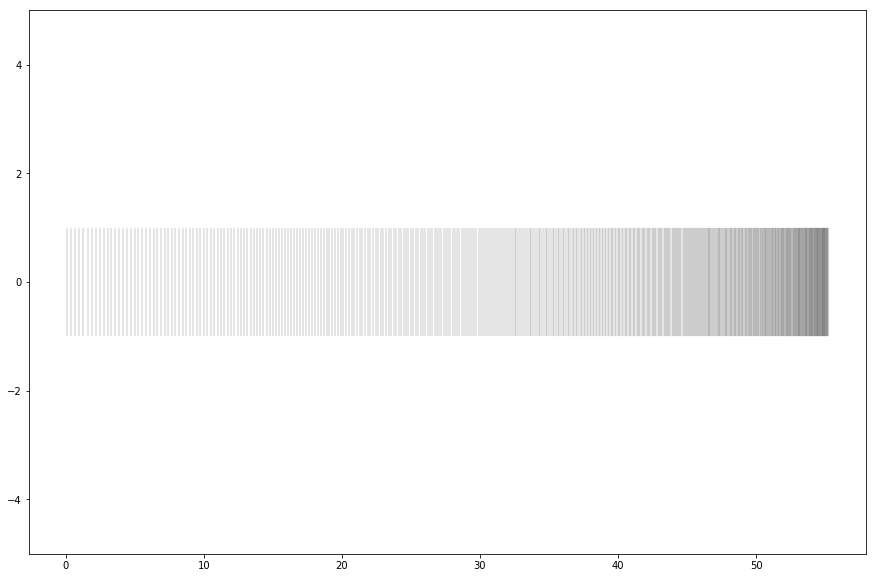

In [229]:
plot_spikes(tonic_inc)

(-5.0, 5.0)

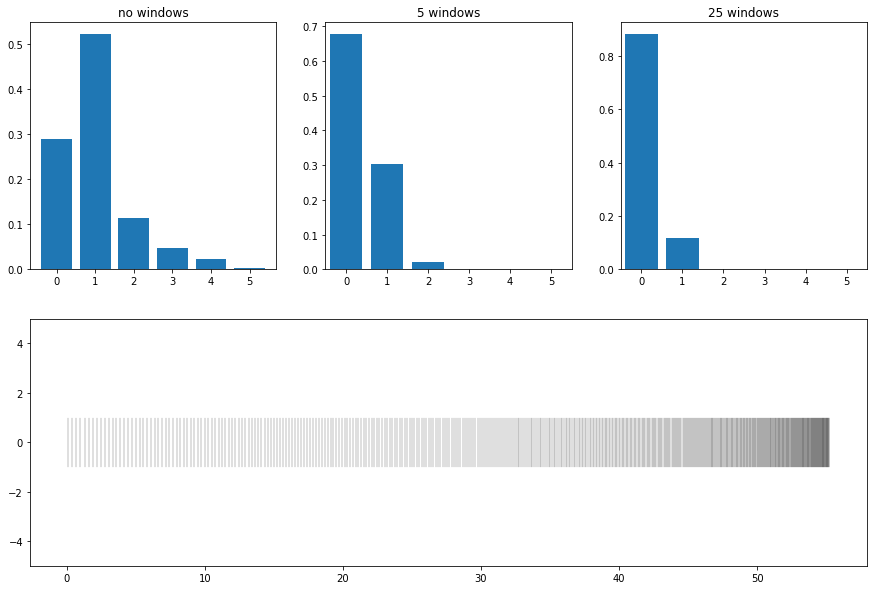

In [275]:
# f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,10))

fig = plt.figure(1, figsize=(15,10))
gridspec.GridSpec(2,3)

sdh = get_sdh(tonic_inc)
plt.subplot2grid((2,3), (0,0))
plt.bar(np.arange(sdh.shape[0]), sdh)
plt.title('no windows')

sdh_w = get_sdh_window(tonic_inc, windows=5)
plt.subplot2grid((2,3), (0,1))
plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
plt.title('5 windows')
plt.xlim([-0.5, 5.5])

sdh_w = get_sdh_window(tonic_inc, windows=25)
plt.subplot2grid((2,3), (0,2))
plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
plt.title('25 windows')
plt.xlim([-0.5, 5.5])

plt.subplot2grid((2,3), (1,0), colspan=3, rowspan=1)
for i in range(len(tonic_inc)):
    plt.plot([tonic_inc[i], tonic_inc[i]], [-1, 1], color='black', lw=0.25)

plt.ylim([-5., 5.])
# plot_spikes(tonic_inc, ax=ax3)

# fig.tight_layout()

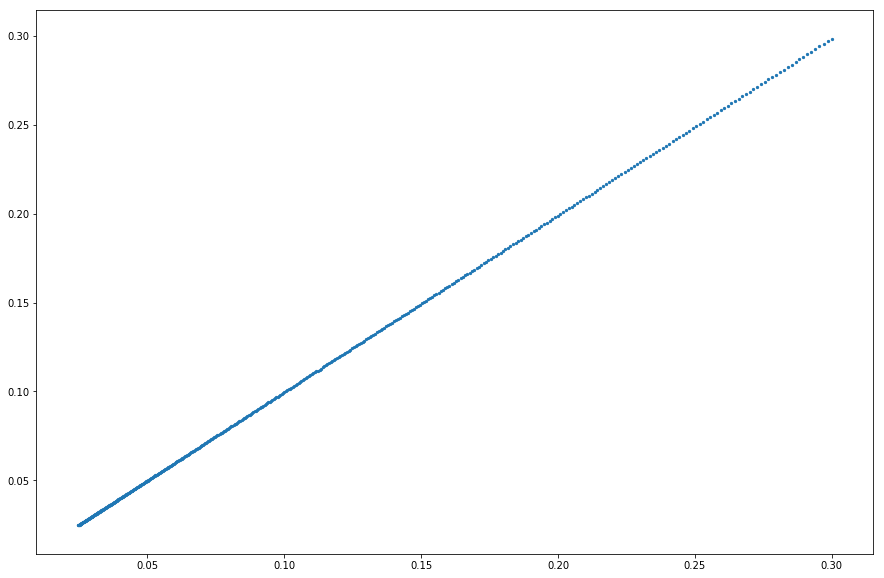

In [279]:
plt.figure(figsize=(15,10))
plt.scatter(isi_inc[:-1], isi_inc[1:], s=5)

In [289]:
st_tonic_sn = [0.1]
isi = 0.05
for i in range(500):
    j = i*np.pi/16
    st_tonic_sn.append(st_tonic_sn[~0] + isi*(np.sin(j) + 1))
    
st_tonic_sn = np.array(st_tonic_sn)
isi_sn = st_tonic_sn[1:]- st_tonic_sn[:-1]

(-5, 5)

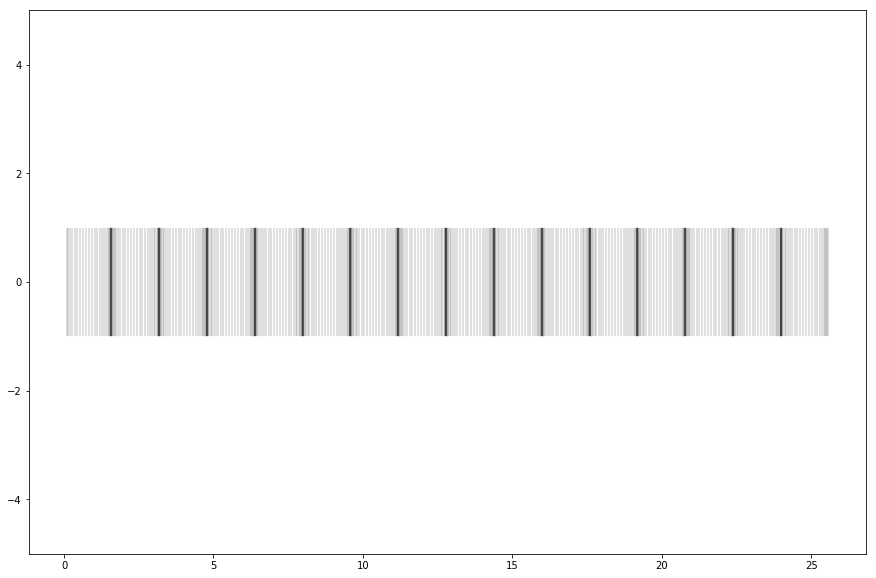

In [288]:
plt.figure(figsize=(15, 10))
for i in range(len(tonic_inc)):
    
    plt.plot([st_tonic_sn[i], st_tonic_sn[i]], [-1, 1], color='black', lw=0.25)

plt.ylim([-5, 5])

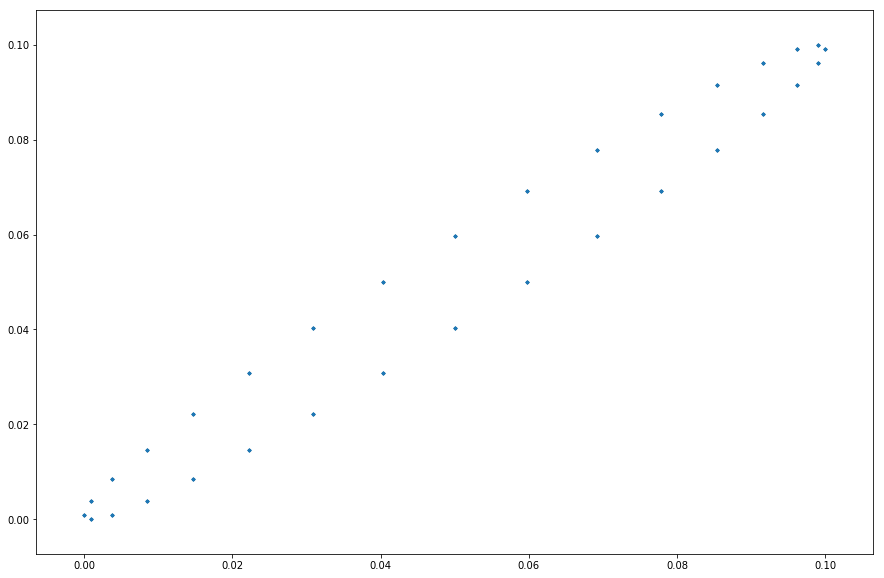

In [290]:
plt.figure(figsize=(15,10))
plt.scatter(isi_sn[:-1], isi_sn[1:], s=5)

In [305]:
d_dct

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b'],
 'dcoord': [[0.0, 0.00056748554488859372, 0.00056748554488859372, 0.0],
  [0.0, 0.00031161829859329207, 0.00031161829859329207, 0.0],
  [0.0, 0.00044380626023749988, 0.00044380626023749988, 0.0],
  [0.00031161829859329207,
   0.0010920296699149475,
   0.0010920296699149475,
   0.000443806260